In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = "data/Loan_Data.csv"
df = pd.read_csv(data_path)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [3]:
dev, val, holdout = np.split(
    df.sample(frac=1, random_state=1),
              [
                  int(.5 * len(df)), 
                  int(.8 * len(df))
              ]
    )

len(dev)

C:\Users\User\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


5000

In [4]:
df.default

0       0
1       1
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: default, Length: 10000, dtype: int64

In [5]:
# Check for sampling errors
print(f"""
Population Default Rate: {round(sum(df.default) * 100 / len(df), 2)}%
Development Sample Default Rate: {round(sum(dev.default) * 100 / len(dev), 2)}%
Validation Sample Default Rate: {round(sum(val.default) * 100 / len(val), 2)}%
Holdout Sample Default Rate: {round(sum(holdout.default) * 100 / len(holdout), 2)}%
""")


Population Default Rate: 18.51%
Development Sample Default Rate: 18.48%
Validation Sample Default Rate: 18.8%
Holdout Sample Default Rate: 18.15%



As seen, simple random sampling is effective in sampling for default rates. Alternatively, we can use stratified random sampling to make the default rate for each group (i.e., development, validation and holdout) more consistent.

In [6]:
from sklearn.model_selection import train_test_split as tts

In [7]:
dev, temp = tts(
    df, 
    test_size = 0.5, 
    stratify = df.default,
    random_state = 1
)

In [8]:
val, holdout = tts(
    temp,
    test_size = 0.4,
    stratify = temp.default,
    random_state = 1
)

In [9]:
print(f"""
Population Default Rate: {round(sum(df.default) * 100 / len(df), 2)}%
Development Sample Default Rate: {round(sum(dev.default) * 100 / len(dev), 2)}%
Validation Sample Default Rate: {round(sum(val.default) * 100 / len(val), 2)}%
Holdout Sample Default Rate: {round(sum(holdout.default) * 100 / len(holdout), 2)}%
""")


Population Default Rate: 18.51%
Development Sample Default Rate: 18.5%
Validation Sample Default Rate: 18.53%
Holdout Sample Default Rate: 18.5%



### Single-variable Logistic Regression Model

In [10]:
import statsmodels.formula.api as sm
import statsmodels.api as sma

my_logit = sm.glm(  # GLM = Generalized Linear Model
    formula = "default ~fico_score", data = dev,
    family = sma.families.Binomial()
).fit()

my_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2113.2
Date:                Wed, 13 Aug 2025   Deviance:                       4226.4
Time:                        22:14:56   Pearson chi2:                 5.01e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1064
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2123      0.441     18.616      0.000       7.348       9.077
fico_score    -0.0156      0.001    -21.608      0.000      -0.017      -0.014
==============================================================================
"""

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(8.2123 - 0.0156)

0.9997245144892916

In [12]:
dev.describe(include = "all")

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.924076e+06,1.463600,4166.299904,8780.301994,70033.145403,4.552000,638.119000,0.185000
std,2.288148e+06,1.741862,1435.044371,6698.144495,20164.543357,1.561084,60.405399,0.388336
min,1.000324e+06,0.000000,57.348647,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.913551e+06,0.000000,3135.359986,4192.718392,56686.278268,3.000000,598.000000,0.000000
50%,4.932271e+06,1.000000,4052.171922,6756.589651,70220.565090,5.000000,638.000000,0.000000
75%,6.871387e+06,2.000000,5058.564804,11496.912522,83316.641957,6.000000,679.000000,0.000000
max,8.996751e+06,5.000000,10467.732060,43688.784100,145404.751500,10.000000,850.000000,1.000000


### Outlier Treatment

Text(0.5, 0, 'fico_score')

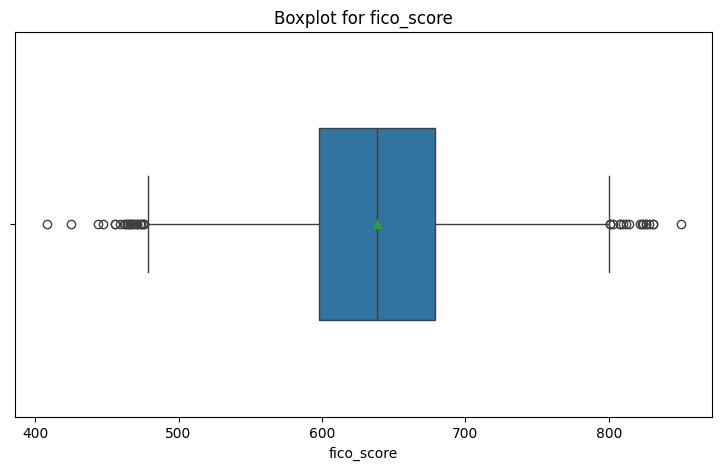

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns  # built on top of plt for better visualization
%matplotlib inline

x = "fico_score"
plt.figure(figsize=(9,5))
boxplot = sns.boxplot(
    x = x,
    data = dev,
    showmeans = True,
    width = 0.5, 
    # palette = "colorblind"
)
plt.title(f"Boxplot for {x}")
plt.xlabel(f"{x}")

Notes:
- As expected, income and fico score have similar boxplots. 
-  Common treatment for outliers is to equate them to their corresponding control limits (e.g., upper, lower)

### Missing Value Imputation

In [14]:
missing_df = df.isnull().sum(axis=0)
missing_df

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

We have a complete dataset. Otherwise, there are various imputation methods:
- initiate NAs to zero
- central measures of tendency (e.g., mean, median, mode)
- k-nearest neighbors
- regression

In [15]:
df.iloc[0, :]

customer_id                 8.153374e+06
credit_lines_outstanding    0.000000e+00
loan_amt_outstanding        5.221545e+03
total_debt_outstanding      3.915471e+03
income                      7.803939e+04
years_employed              5.000000e+00
fico_score                  6.050000e+02
default                     0.000000e+00
Name: 0, dtype: float64

In [16]:
# variables = "default ~ credit_lines_outstanding + loan_amt_outstanding + total_debt_outstanding + income + years_employed + fico_score"

In [17]:
new_df = df.copy()
# df["debt_income_ratio"] = df["loan_amt_outstanding"] / df 

In [18]:
new_df["debt_income_ratio"] = df["total_debt_outstanding"] / df["income"]
new_df["loan_income_ratio"] = df["loan_amt_outstanding"] / df["income"]

In [19]:
new_df.describe(include = "all")

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100,0.124018,0.059423
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398,0.082802,0.010642
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000,0.010000,0.012249
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000,0.068533,0.052125
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000,0.097434,0.059517
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000,0.163385,0.066717
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000,0.404561,0.102103


| Variable                       |          Purpose                  | Statistical Measure                             |
| ------------------------------ | --------------------------------- | -------------------------------------------------------------- |
| **credit\_lines\_outstanding** | Shows borrower’s access to credit | Min, max, median, 75th percentile, and distribution shape      |
| **loan\_amt\_outstanding**     | Size of loan burden               | Percentiles, outliers, relation to income                      |
| **total\_debt\_outstanding**   | Total obligations                 | Same as above; see if it’s heavily skewed                      |
| **income**                     | Borrower’s repayment capacity     | Distribution and whether it spans multiple orders of magnitude |
| **years\_employed**            | Job stability                     | Distribution, any caps (e.g., 40 years)                        |
| **fico\_score**                | Industry-standard credit score    | Range (likely 300–850), median, where default rate jumps       |
| **default**                    | Binary outcome                    | Only used to check event rate in each bin later                |
| **debt\_income\_ratio**        | Debt burden relative to income    | Min, max, 25/50/75th percentiles, and where defaults spike     |
| **loan\_income\_ratio**        | Loan size relative to income      | Same idea as DTI                                               |


In [20]:
new_df.columns.tolist()

['customer_id',
 'credit_lines_outstanding',
 'loan_amt_outstanding',
 'total_debt_outstanding',
 'income',
 'years_employed',
 'fico_score',
 'default',
 'debt_income_ratio',
 'loan_income_ratio']

In [21]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [22]:
for col in [
 'credit_lines_outstanding',
 'loan_amt_outstanding',
 'total_debt_outstanding',
 'income',
 'years_employed',
 'fico_score',
 'default',
 'debt_income_ratio',
 'loan_income_ratio']:
    print(f"\n--- {col} ---")
    print(new_df[col].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


--- credit_lines_outstanding ---
count   10000.000
mean        1.461
std         1.744
min         0.000
10%         0.000
25%         0.000
50%         1.000
75%         2.000
90%         5.000
95%         5.000
99%         5.000
max         5.000
Name: credit_lines_outstanding, dtype: float64

--- loan_amt_outstanding ---
count   10000.000
mean     4159.677
std      1421.399
min        46.784
10%      2438.945
25%      3154.235
50%      4052.377
75%      5052.898
90%      6053.180
95%      6646.027
99%      7923.322
max     10750.678
Name: loan_amt_outstanding, dtype: float64

--- total_debt_outstanding ---
count   10000.000
mean     8718.917
std      6627.165
min        31.653
10%      2291.468
25%      4199.836
50%      6732.407
75%     11272.264
90%     18691.477
95%     22900.196
99%     29708.836
max     43688.784
Name: total_debt_outstanding, dtype: float64

--- income ---
count    10000.000
mean     70039.901
std      20072.214
min       1000.000
10%      44596.250
25%      5

## Bin Cutoffs

### **1. credit\_lines\_outstanding** (0–5, discrete)

**Idea:** This is already discrete, so binning can be done as small groups.

**Suggested bins:**

```
Bin 1: 0 lines
Bin 2: 1–2 lines
Bin 3: 3–5 lines
```

---

### **2. loan\_amt\_outstanding** (≈ \$47 – \$10,750)

Median is \~\$4,052, 75% is \~\$5,053.

**Suggested bins:**

```
Bin 1: < $3,000
Bin 2: $3,000 – $4,500
Bin 3: $4,500 – $6,000
Bin 4: > $6,000
```

---

### **3. total\_debt\_outstanding** (≈ \$32 – \$43,689)

Median \~\$6,732, 75% \~\$11,272.

**Suggested bins:**

```
Bin 1: < $5,000
Bin 2: $5,000 – $8,000
Bin 3: $8,000 – $12,000
Bin 4: > $12,000
```

---

### **4. income** (\$1,000 – \$148,412, median \~\$70k)

Big range — wide bins make more sense here.

**Suggested bins:**

```
Bin 1: < $50,000
Bin 2: $50,000 – $70,000
Bin 3: $70,000 – $90,000
Bin 4: > $90,000
```

---

### **5. years\_employed** (0–10, median 5)

Discrete integers, small range.

**Suggested bins:**

```
Bin 1: 0–2 years
Bin 2: 3–5 years
Bin 3: 6–8 years
Bin 4: 9–10 years
```

---

### **6. fico\_score** (408 – 850, median \~638)

Industry categories for FICO usually guide bins here.

**Suggested bins:**

```
Bin 1: < 580   (Poor)
Bin 2: 580–669 (Fair)
Bin 3: 670–739 (Good)
Bin 4: ≥ 740   (Very Good / Excellent)
```

---

### **7. debt\_income\_ratio** (0.01 – 0.40, median 0.097)

This is your **DTI** measure; values above \~0.4 are rare.

**Suggested bins:**

```
Bin 1: ≤ 0.07
Bin 2: 0.07 – 0.10
Bin 3: 0.10 – 0.16
Bin 4: > 0.16
```

---

### **8. loan\_income\_ratio** (0.012 – 0.102, median \~0.06)

Similar to PTI; very small range.

**Suggested bins:**

```
Bin 1: ≤ 0.052
Bin 2: 0.052 – 0.060
Bin 3: 0.060 – 0.067
Bin 4: > 0.067
```

---

In [23]:
bin_specs = {
    'credit_lines_outstanding': [-1, 0, 2, 5],
    'loan_amt_outstanding': [-float('inf'), 3000, 4500, 6000, float('inf')],
    'total_debt_outstanding': [-float('inf'), 5000, 8000, 12000, float('inf')],
    'income': [-float('inf'), 50000, 70000, 90000, float('inf')],
    'years_employed': [-1, 2, 5, 8, 10], 
    'fico_score': [-float('inf'), 580, 670, 740, float('inf')],
    'debt_income_ratio': [-float('inf'), 0.07, 0.10, 0.16, float('inf')], 
    'loan_income_ratio': [-float('inf'), 0.052, 0.060, 0.067, float('inf')]
}

In [24]:
for col, bins in bin_specs.items():
    new_df[col + '_bin'] = pd.cut(new_df[col], bins=bins)

new_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio,credit_lines_outstanding_bin,loan_amt_outstanding_bin,total_debt_outstanding_bin,income_bin,years_employed_bin,fico_score_bin,debt_income_ratio_bin,loan_income_ratio_bin
0,8153374,0,5221.545,3915.471,78039.385,5,605,0,0.050,0.067,"(-1, 0]","(4500.0, 6000.0]","(-inf, 5000.0]","(70000.0, 90000.0]","(2, 5]","(580.0, 670.0]","(-inf, 0.07]","(0.06, 0.067]"
1,7442532,5,1958.929,8228.753,26648.435,2,572,1,0.309,0.074,"(2, 5]","(-inf, 3000.0]","(8000.0, 12000.0]","(-inf, 50000.0]","(-1, 2]","(-inf, 580.0]","(0.16, inf]","(0.067, inf]"
2,2256073,0,3363.009,2027.831,65866.712,4,602,0,0.031,0.051,"(-1, 0]","(3000.0, 4500.0]","(-inf, 5000.0]","(50000.0, 70000.0]","(2, 5]","(580.0, 670.0]","(-inf, 0.07]","(-inf, 0.052]"
3,4885975,0,4766.648,2501.730,74356.883,5,612,0,0.034,0.064,"(-1, 0]","(4500.0, 6000.0]","(-inf, 5000.0]","(70000.0, 90000.0]","(2, 5]","(580.0, 670.0]","(-inf, 0.07]","(0.06, 0.067]"
4,4700614,1,1345.828,1768.826,23448.326,6,631,0,0.075,0.057,"(0, 2]","(-inf, 3000.0]","(-inf, 5000.0]","(-inf, 50000.0]","(5, 8]","(580.0, 670.0]","(0.07, 0.1]","(0.052, 0.06]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647,2553.733,42691.628,5,697,0,0.060,0.071,"(-1, 0]","(3000.0, 4500.0]","(-inf, 5000.0]","(-inf, 50000.0]","(2, 5]","(670.0, 740.0]","(-inf, 0.07]","(0.067, inf]"
9996,6184073,1,4146.239,5458.164,79969.505,8,615,0,0.068,0.052,"(0, 2]","(3000.0, 4500.0]","(5000.0, 8000.0]","(70000.0, 90000.0]","(5, 8]","(580.0, 670.0]","(-inf, 0.07]","(-inf, 0.052]"
9997,6694516,2,3088.224,4813.091,38192.676,5,596,0,0.126,0.081,"(0, 2]","(3000.0, 4500.0]","(-inf, 5000.0]","(-inf, 50000.0]","(2, 5]","(580.0, 670.0]","(0.1, 0.16]","(0.067, inf]"
9998,3942961,0,3288.902,1043.100,50929.372,2,647,0,0.020,0.065,"(-1, 0]","(3000.0, 4500.0]","(-inf, 5000.0]","(50000.0, 70000.0]","(-1, 2]","(580.0, 670.0]","(-inf, 0.07]","(0.06, 0.067]"


In [25]:
def default_rate_per_bin(df, col_bin):
    return (
        df.groupby(col_bin)['default']
        .agg(['count', 'sum', 'mean'])
        .rename(columns = {'sum': 'defaults', 'mean': 'default_rate'})
        .reset_index()
    )

In [26]:
for col in bin_specs.keys():
    print(f"\n --- {col.upper()} ---")
    result = default_rate_per_bin(new_df, col+"_bin")
    print(result)


 --- CREDIT_LINES_OUTSTANDING ---
  credit_lines_outstanding_bin  count  defaults  default_rate
0                      (-1, 0]   4128         0         0.000
1                       (0, 2]   3492         7         0.002
2                       (2, 5]   2380      1844         0.775

 --- LOAN_AMT_OUTSTANDING ---
  loan_amt_outstanding_bin  count  defaults  default_rate
0           (-inf, 3000.0]   2084       285         0.137
1         (3000.0, 4500.0]   4142       689         0.166
2         (4500.0, 6000.0]   2724       597         0.219
3            (6000.0, inf]   1050       280         0.267

 --- TOTAL_DEBT_OUTSTANDING ---
  total_debt_outstanding_bin  count  defaults  default_rate
0             (-inf, 5000.0]   3296        12         0.004
1           (5000.0, 8000.0]   2658        39         0.015
2          (8000.0, 12000.0]   1741       154         0.088
3             (12000.0, inf]   2305      1646         0.714

 --- INCOME ---
           income_bin  count  defaults  defaul

C:\Users\User\AppData\Local\Temp\ipykernel_4616\1068397845.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col_bin)['default']
C:\Users\User\AppData\Local\Temp\ipykernel_4616\1068397845.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col_bin)['default']
C:\Users\User\AppData\Local\Temp\ipykernel_4616\1068397845.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col_bin)['default'

## **Weight of Evidence (WOE)**
---

### **Significance**

* **Logistic regression** assumes a *linear* relationship between the independent variable and the log-odds of default.
* Raw variables often have **non-linear** or inconsistent relationships.
* **WOE transformation** makes the predictor monotonic with default risk and stabilizes model performance.
* It also handles categorical data cleanly after binning.

---

### **Steps**

1. Use your binned variables (from the last step).
2. For each bin:

   * Count **Good** (non-default) and **Bad** (default) observations.
   * Compute WOE =

     $$
     \text{WOE} = \ln\left(\frac{\text{\% Good in bin}}{\text{\% Bad in bin}}\right)
     $$
3. Replace the bin values with the computed WOE value for logistic regression input.


### **What you’ll see**

For each binned variable, you’ll get something like:

```
loan_amt_outstanding_bin  count  good   bad       woe       iv
(-inf, 3000]               2200  2100   100   0.7654   0.0453
(3000, 4500]               2500  2300   200   0.3211   0.0224
(4500, 6000]               2800  2400   400  -0.2108   0.0102
(6000, inf]                2500  2000   500  -0.5124   0.0521
```

---

### **How we’ll use this**

* For the **logistic regression** model, we’ll replace each bin with its **WOE value**. This turns our categorical bins into continuous predictors with a monotonic relationship to default probability.
* The **IV (Information Value)** will help us decide if a variable is worth keeping:

  * **< 0.02** → Not predictive
  * **0.02–0.1** → Weak predictor
  * **0.1–0.3** → Medium predictor
  * **> 0.3** → Strong predictor

---



In [27]:
def compute_woe_iv(df, var_bin, target = 'default', bins = None, k = 0.5):
    grouped = df.groupby(var_bin)[target].agg(['count', 'sum'])
    grouped['good'] = grouped['count'] - grouped['sum']
    grouped['bad'] = grouped['sum']

    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()

    # smoothing to avoid zero counts
    grouped['%good'] = (grouped['good'] + k) / (total_good + 2*k)
    grouped['%bad'] = (grouped['bad'] + k) / (total_bad + 2*k)

    # Laplace smoothing to avoid zero division
    grouped['woe'] = np.log(
        grouped['%good'] / grouped['%bad']
    )

    grouped['iv'] = ( grouped['%good'] - grouped['%bad']  ) * grouped['woe']
    return grouped.reset_index()

In [28]:
# woe_table = compute_woe_iv(df, 

In [29]:
woe_tables = {}
for col in bin_specs.keys():
    col_bin = col + '_bin'
    woe_table = compute_woe_iv(new_df, col_bin)
    woe_tables[col] = woe_table
    print(f"\n--- {col.upper()} ---")
    print(woe_table)


--- CREDIT_LINES_OUTSTANDING ---
  credit_lines_outstanding_bin  count   sum  good   bad  %good  %bad    woe  \
0                      (-1, 0]   4128     0  4128     0  0.507 0.000  7.537   
1                       (0, 2]   3492     7  3485     7  0.428 0.004  4.660   
2                       (2, 5]   2380  1844   536  1844  0.066 0.996 -2.717   

     iv  
0 3.816  
1 1.974  
2 2.527  

--- LOAN_AMT_OUTSTANDING ---
  loan_amt_outstanding_bin  count  sum  good  bad  %good  %bad    woe    iv
0           (-inf, 3000.0]   2084  285  1799  285  0.221 0.154  0.359 0.024
1         (3000.0, 4500.0]   4142  689  3453  689  0.424 0.372  0.129 0.007
2         (4500.0, 6000.0]   2724  597  2127  597  0.261 0.323 -0.212 0.013
3            (6000.0, inf]   1050  280   770  280  0.095 0.151 -0.471 0.027

--- TOTAL_DEBT_OUTSTANDING ---
  total_debt_outstanding_bin  count   sum  good   bad  %good  %bad    woe  \
0             (-inf, 5000.0]   3296    12  3284    12  0.403 0.007  4.089   
1           (

C:\Users\User\AppData\Local\Temp\ipykernel_4616\1414305288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(var_bin)[target].agg(['count', 'sum'])
C:\Users\User\AppData\Local\Temp\ipykernel_4616\1414305288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(var_bin)[target].agg(['count', 'sum'])
C:\Users\User\AppData\Local\Temp\ipykernel_4616\1414305288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default


--- LOAN_INCOME_RATIO ---
  loan_income_ratio_bin  count  sum  good  bad  %good  %bad    woe    iv
0         (-inf, 0.052]   2456  265  2191  265  0.269 0.143  0.629 0.079
1         (0.052, 0.06]   2745  435  2310  435  0.283 0.235  0.187 0.009
2         (0.06, 0.067]   2385  497  1888  497  0.232 0.269 -0.148 0.005
3          (0.067, inf]   2414  654  1760  654  0.216 0.353 -0.492 0.068


**Extreme WOE Problem**
- some bins have zero default counts, making their woe values explode
- to resolve this, you would need to perform bin merging
- this ensures that each bin has a minimum number of default samples (e.g., at least one)

Since we are still observing extremes, this implies that our bins contain imbalanced groups for either defaults or non-defaults. From the adjusted WOE scores, we will merge bins with adjacent bins if their corresponding WOE is unusual (i.e., |WOE| > 3). 


### Suggested fix:
| Variable                       | Current Problem                       | Adjustment                                             |
| ------------------------------ | ------------------------------------- | ------------------------------------------------------ |
| **credit\_lines\_outstanding** | First bin has WOE = 7.54, 0 bads      | Merge bins (-1,0] and (0,2], re-check monotonicity     |
| **loan\_amt\_outstanding**     | Already fine, low IV                  | Keep as is, but check if further compression is needed |
| **total\_debt\_outstanding**   | First two bins very high WOE          | Merge first 2 bins, last two bins separately           |
| **income**                     | Very low IV                           | Drop entirely                                          |
| **years\_employed**            | Small bin with 54 people, extreme WOE | Merge last bin with (5,8]                              |
| **fico\_score**                | OK                                    | Keep as is                                             |
| **debt\_income\_ratio**        | First three bins perfect separation   | Merge first 3 bins together                            |
| **loan\_income\_ratio**        | Fine                                  | Keep as is                                             |


In [30]:
bin_specs = {
    # Merge (-1, 0] and (0, 2] → to avoid 0 bads problem
    'credit_lines_outstanding': [-1, 2, 5],

    # Already fine
    'loan_amt_outstanding': [-float('inf'), 3000, 4500, 6000, float('inf')],

    # Merge first two bins with high WOE
    'total_debt_outstanding': [-float('inf'), 8000, 12000, float('inf')],

    # Very low IV — you might drop this variable, but keeping for now
    'income': [-float('inf'), 50000, 70000, 90000, float('inf')],

    # Merge last bin (8,10] with (5,8]
    'years_employed': [-1, 2, 5, 10],

    # Fine
    'fico_score': [-float('inf'), 580, 670, 740, float('inf')],

    # Merge first 3 bins into 1 due to perfect separation
    'debt_income_ratio': [-float('inf'), 0.10, 0.16, float('inf')],

    # Fine
    'loan_income_ratio': [-float('inf'), 0.052, 0.060, 0.067, float('inf')]
}

# Apply binning
for col, bins in bin_specs.items():
    new_df[col + '_bin'] = pd.cut(new_df[col], bins=bins, include_lowest=True)

new_df.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_income_ratio,loan_income_ratio,credit_lines_outstanding_bin,loan_amt_outstanding_bin,total_debt_outstanding_bin,income_bin,years_employed_bin,fico_score_bin,debt_income_ratio_bin,loan_income_ratio_bin
0,8153374,0,5221.545,3915.471,78039.385,5,605,0,0.050,0.067,"(-1.001, 2.0]","(4500.0, 6000.0]","(-inf, 8000.0]","(70000.0, 90000.0]","(2.0, 5.0]","(580.0, 670.0]","(-inf, 0.1]","(0.06, 0.067]"
1,7442532,5,1958.929,8228.753,26648.435,2,572,1,0.309,0.074,"(2.0, 5.0]","(-inf, 3000.0]","(8000.0, 12000.0]","(-inf, 50000.0]","(-1.001, 2.0]","(-inf, 580.0]","(0.16, inf]","(0.067, inf]"
2,2256073,0,3363.009,2027.831,65866.712,4,602,0,0.031,0.051,"(-1.001, 2.0]","(3000.0, 4500.0]","(-inf, 8000.0]","(50000.0, 70000.0]","(2.0, 5.0]","(580.0, 670.0]","(-inf, 0.1]","(-inf, 0.052]"
3,4885975,0,4766.648,2501.730,74356.883,5,612,0,0.034,0.064,"(-1.001, 2.0]","(4500.0, 6000.0]","(-inf, 8000.0]","(70000.0, 90000.0]","(2.0, 5.0]","(580.0, 670.0]","(-inf, 0.1]","(0.06, 0.067]"
4,4700614,1,1345.828,1768.826,23448.326,6,631,0,0.075,0.057,"(-1.001, 2.0]","(-inf, 3000.0]","(-inf, 8000.0]","(-inf, 50000.0]","(5.0, 10.0]","(580.0, 670.0]","(-inf, 0.1]","(0.052, 0.06]"


In [31]:
woe_tables = {}
for col in bin_specs.keys():
    col_bin = col + '_bin'
    woe_table = compute_woe_iv(new_df, col_bin)
    woe_tables[col] = woe_table
    print(f"\n--- {col.upper()} ---")
    print(woe_table)


--- CREDIT_LINES_OUTSTANDING ---
  credit_lines_outstanding_bin  count   sum  good   bad  %good  %bad    woe  \
0                (-1.001, 2.0]   7620     7  7613     7  0.934 0.004  5.441   
1                   (2.0, 5.0]   2380  1844   536  1844  0.066 0.996 -2.717   

     iv  
0 5.061  
1 2.527  

--- LOAN_AMT_OUTSTANDING ---
  loan_amt_outstanding_bin  count  sum  good  bad  %good  %bad    woe    iv
0           (-inf, 3000.0]   2084  285  1799  285  0.221 0.154  0.359 0.024
1         (3000.0, 4500.0]   4142  689  3453  689  0.424 0.372  0.129 0.007
2         (4500.0, 6000.0]   2724  597  2127  597  0.261 0.323 -0.212 0.013
3            (6000.0, inf]   1050  280   770  280  0.095 0.151 -0.471 0.027

--- TOTAL_DEBT_OUTSTANDING ---
  total_debt_outstanding_bin  count   sum  good   bad  %good  %bad    woe  \
0             (-inf, 8000.0]   5954    51  5903    51  0.724 0.028  3.260   
1          (8000.0, 12000.0]   1741   154  1587   154  0.195 0.083  0.848   
2             (12000.0, i

C:\Users\User\AppData\Local\Temp\ipykernel_4616\1414305288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(var_bin)[target].agg(['count', 'sum'])
C:\Users\User\AppData\Local\Temp\ipykernel_4616\1414305288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(var_bin)[target].agg(['count', 'sum'])
C:\Users\User\AppData\Local\Temp\ipykernel_4616\1414305288.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

In [32]:
# bin_specs = {
#     # Merge bins to avoid perfect separation & extreme WOE
#     'credit_lines_outstanding': [-1, 1, 5],  
#     # (was 0-2 and 2-5, but first bin was too dominant)

#     'loan_amt_outstanding': [-float('inf'), 3000, 4500, 6000, float('inf')],
#     # Already balanced, just keep

#     'total_debt_outstanding': [-float('inf'), 8000, 12000, float('inf')],
#     # Merge first two bins (0 bad issue in first bin) into <=8000

#     'income': [-float('inf'), 50000, 70000, 90000, float('inf')],
#     # Already well distributed

#     'years_employed': [-1, 2, 5, 10],
#     # Merge last two (5-8, 8-10) into one because small bad counts

#     'fico_score': [-float('inf'), 580, 670, 740, float('inf')],
#     # Already reasonable spread

#     'debt_income_ratio': [-float('inf'), 0.16, float('inf')],
#     # Merge first two bins to avoid zero bad problem

#     'loan_income_ratio': [-float('inf'), 0.052, 0.06, 0.067, float('inf')]
#     # Seems balanced, keep as is
# }


In [33]:
# # Apply binning
# for col, bins in bin_specs.items():
#     new_df[col + '_bin'] = pd.cut(new_df[col], bins=bins, include_lowest=True)

# new_df.head()

In [34]:
# woe_tables = {}
# for col in bin_specs.keys():
#     col_bin = col + '_bin'
#     woe_table = compute_woe_iv(new_df, col_bin)
#     woe_tables[col] = woe_table
#     print(f"\n--- {col.upper()} ---")
#     print(woe_table)

## Model training

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# WOE dictionary
woe_dict = {
    'credit_lines_outstanding_bin': {
        '(-1.001, 2.0]': 5.441,
        '(2.0, 5.0]': -2.717
    },
    'loan_amt_outstanding_bin': {
        '(-inf, 3000.0]': 0.359,
        '(3000.0, 4500.0]': 0.129,
        '(4500.0, 6000.0]': -0.212,
        '(6000.0, inf]': -0.471
    },
    'total_debt_outstanding_bin': {
        '(-inf, 8000.0]': 3.260,
        '(8000.0, 12000.0]': 0.848,
        '(12000.0, inf]': -2.397
    },
    'income_bin': {
        '(-inf, 50000.0]': 0.017,
        '(50000.0, 70000.0]': 0.071,
        '(70000.0, 90000.0]': -0.054,
        '(90000.0, inf]': -0.047
    },
    'years_employed_bin': {
        '(-1.001, 2.0]': -1.041,
        '(2.0, 5.0]': -0.142,
        '(5.0, 10.0]': 1.226
    },
    'fico_score_bin': {
        '(-inf, 580.0]': -1.201,
        '(580.0, 670.0]': 0.090,
        '(670.0, 740.0]': 1.045,
        '(740.0, inf]': 1.998
    },
    'debt_income_ratio_bin': {
        '(-inf, 0.1]': 7.773,
        '(0.1, 0.16]': 6.920,
        '(0.16, inf]': -2.455
    },
    'loan_income_ratio_bin': {
        '(-inf, 0.052]': 0.629,
        '(0.052, 0.06]': 0.187,
        '(0.06, 0.067]': -0.148,
        '(0.067, inf]': -0.492
    }
}

# List of WOE columns
woe_features = []

# Map WOE and handle inf / -inf / NaN
for bin_col, mapping in woe_dict.items():
    woe_col = bin_col.replace('_bin', '_woe')
    new_df[woe_col] = new_df[bin_col].map(mapping)
    
    # Replace inf/-inf with max/min finite values
    finite_vals = new_df[woe_col].replace([np.inf, -np.inf], np.nan).dropna()
    if not finite_vals.empty:
        new_df[woe_col].replace(np.inf, finite_vals.max(), inplace=True)
        new_df[woe_col].replace(-np.inf, finite_vals.min(), inplace=True)
    
    # Replace remaining NaNs with median
    new_df[woe_col].fillna(finite_vals.median() if not finite_vals.empty else 0, inplace=True)
    
    woe_features.append(woe_col)

# Define predictors and target
X = new_df[woe_features]
y = new_df['default']

# Add intercept
X = sm.add_constant(X)

# Fit GLM
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
model = glm_binom.fit()

# Summary
print(model.summary())

# Predicted probability of default
new_df['pd'] = model.predict(X)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9999
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4790.4
Date:                Wed, 13 Aug 2025   Deviance:                       9580.8
Time:                        22:14:59   Pearson chi2:                 1.00e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          2.220e-16
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [38]:
new_df[woe_features].describe()
new_df[woe_features].isna().sum()


credit_lines_outstanding_woe    0
loan_amt_outstanding_woe        0
total_debt_outstanding_woe      0
income_woe                      0
years_employed_woe              0
fico_score_woe                  0
debt_income_ratio_woe           0
loan_income_ratio_woe           0
dtype: int64

In [37]:
for col in bin_specs.keys():
    print(new_df[col + '_bin'].value_counts())



credit_lines_outstanding_bin
(-1.001, 2.0]    7620
(2.0, 5.0]       2380
Name: count, dtype: int64
loan_amt_outstanding_bin
(3000.0, 4500.0]    4142
(4500.0, 6000.0]    2724
(-inf, 3000.0]      2084
(6000.0, inf]       1050
Name: count, dtype: int64
total_debt_outstanding_bin
(-inf, 8000.0]       5954
(12000.0, inf]       2305
(8000.0, 12000.0]    1741
Name: count, dtype: int64
income_bin
(70000.0, 90000.0]    3449
(50000.0, 70000.0]    3379
(-inf, 50000.0]       1595
(90000.0, inf]        1577
Name: count, dtype: int64
years_employed_bin
(2.0, 5.0]       6453
(5.0, 10.0]      2663
(-1.001, 2.0]     884
Name: count, dtype: int64
fico_score_bin
(580.0, 670.0]    5329
(670.0, 740.0]    2546
(-inf, 580.0]     1708
(740.0, inf]       417
Name: count, dtype: int64
debt_income_ratio_bin
(-inf, 0.1]    5224
(0.16, inf]    2550
(0.1, 0.16]    2226
Name: count, dtype: int64
loan_income_ratio_bin
(0.052, 0.06]    2745
(-inf, 0.052]    2456
(0.067, inf]     2414
(0.06, 0.067]    2385
Name: count,

In [40]:
for col in bin_specs.keys():
    bin_col = col + '_bin'
    woe_col = col + '_woe'
    new_df[woe_col] = new_df[bin_col].map(woe_dict[bin_col])
    print(woe_col, new_df[woe_col].unique())


credit_lines_outstanding_woe [nan]
loan_amt_outstanding_woe [nan]
total_debt_outstanding_woe [nan]
income_woe [nan]
years_employed_woe [nan]
fico_score_woe [nan]
debt_income_ratio_woe [nan]
loan_income_ratio_woe [nan]
